## Session 10 - Image search with VGG16 and K-Nearest Neighbours

In [1]:
# base tools
import os, sys
sys.path.append(os.path.join(".."))

# data analysis
import numpy as np
from numpy.linalg import norm
from tqdm import notebook

# tensorflow
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import (load_img, 
                                                  img_to_array)
from tensorflow.keras.applications.vgg16 import (VGG16, 
                                                 preprocess_input)
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2023-04-27 10:43:55.466885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Helper functions

Q: What kind of preprocessing am I doing here? Why do you think I'm doing it?

In [2]:
def extract_features(img_path, model):
    """
    Extract features from image data using pretrained model (e.g. VGG16)
    """
    # Define input image shape - remember we need to reshape
    input_shape = (224, 224, 3)
    # load image from file path
    img = load_img(img_path, target_size=(input_shape[0], 
                                          input_shape[1]))
    # convert to array
    img_array = img_to_array(img)
    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # preprocess image - see last week's notebook
    preprocessed_img = preprocess_input(expanded_img_array)
    # use the predict function to create feature representation
    features = model.predict(preprocessed_img)
    # flatten
    flattened_features = features.flatten()
    # normalise features
    normalized_features = flattened_features / norm(features) # you can divide by 255. instead
    return normalized_features

# Image search

## Load VGG16

In [3]:
model = VGG16(weights='imagenet', 
              include_top=False,
              pooling='avg',
              input_shape=(224, 224, 3))

## Extract features from single image

In [4]:
features = extract_features('../data/img/florence.jpg', model)

1/1 [==============================] - 1s 619ms/step


## Iterate over folder

In [6]:
# path to the datasets
root_dir = os.path.join("..", "data", "flowers") 
filenames = [root_dir + "/" + name for name in sorted(os.listdir(root_dir))]

In [7]:
filenames

['../data/flowers/.ipynb_checkpoints',
 '../data/flowers/image_0001.jpg',
 '../data/flowers/image_0002.jpg',
 '../data/flowers/image_0003.jpg',
 '../data/flowers/image_0004.jpg',
 '../data/flowers/image_0005.jpg',
 '../data/flowers/image_0006.jpg',
 '../data/flowers/image_0007.jpg',
 '../data/flowers/image_0008.jpg',
 '../data/flowers/image_0009.jpg',
 '../data/flowers/image_0010.jpg',
 '../data/flowers/image_0011.jpg',
 '../data/flowers/image_0012.jpg',
 '../data/flowers/image_0013.jpg',
 '../data/flowers/image_0014.jpg',
 '../data/flowers/image_0015.jpg',
 '../data/flowers/image_0016.jpg',
 '../data/flowers/image_0017.jpg',
 '../data/flowers/image_0018.jpg',
 '../data/flowers/image_0019.jpg',
 '../data/flowers/image_0020.jpg',
 '../data/flowers/image_0021.jpg',
 '../data/flowers/image_0022.jpg',
 '../data/flowers/image_0023.jpg',
 '../data/flowers/image_0024.jpg',
 '../data/flowers/image_0025.jpg',
 '../data/flowers/image_0026.jpg',
 '../data/flowers/image_0027.jpg',
 '../data/flower

__Extract features for each image__

In [14]:
feature_list = []
for i in notebook.tqdm(range(len(filenames)), position=0, leave=True):
    if filenames[i].endswith(".jpg"):
        feature_list.append(extract_features(filenames[i], model))

  0%|          | 0/1361 [00:00<?, ?it/s]

1/1 [==============================] - 0s 233ms/step


## Nearest neighbours

Once we have our *database* of extracted embeddings, we can then use K-Nearest Neighbours to find similar images.

In [15]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10, 
                             algorithm='brute',
                             metric='cosine').fit(feature_list)

__Calculate nearest neighbours for target__

In [16]:
distances, indices = neighbors.kneighbors([feature_list[250]])

__Save indices, print data__

In [17]:
# showing images closest to chosen image
idxs = []
for i in range(1,6):
    print(distances[0][i], indices[0][i])
    idxs.append(indices[0][i])

0.14842784 248
0.21073085 249
0.2119897 245
0.22384572 244
0.22834098 240


__Plot target image__

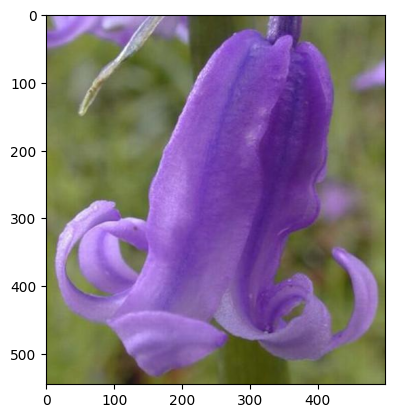

In [18]:
# showing chosen image
plt.imshow(mpimg.imread(filenames[250]))

__Plot close images__

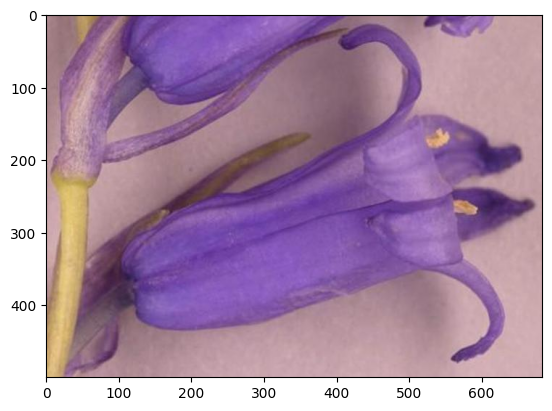

In [19]:
# showing closest image
plt.imshow(mpimg.imread(filenames[248]))

__Plot target and top 3 closest together__

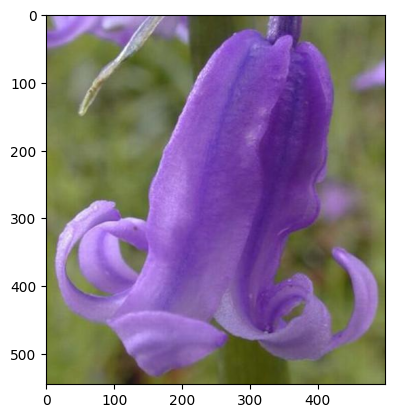

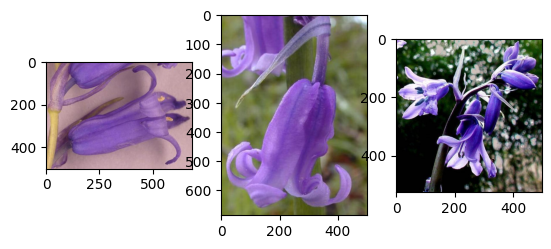

In [20]:
# plt target
plt.imshow(mpimg.imread(filenames[250]))

# plot 3 most similar
f, axarr = plt.subplots(1,3)
axarr[0].imshow(mpimg.imread(filenames[idxs[0]]))
axarr[1].imshow(mpimg.imread(filenames[idxs[1]]))
axarr[2].imshow(mpimg.imread(filenames[idxs[2]]))

## Simple style transfer

__Load a quick style transfer model from TF Hub__

You can find more details [here](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)

In [21]:
# load TF-Hub module
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

__Load the content image and the style image__

In [22]:
# loading images and styles
content_image = st_load("../data/img/florence.jpg")
style_image = st_load("../data/img/starry_night.jpg")

NameError: name 'st_load' is not defined

__Process using the model__

In [23]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

NameError: name 'content_image' is not defined

__Show content, style, and stylized image__

In [ ]:
show_n([content_image, style_image, stylized_image], 
       titles=['Original content image', 'Style image', 'Stylized image'])

### Task1 
- Run this same pipeline on the Indo Fashion dataset. How does it perform?

### Task 2
- Take the code in this notebook and turn it into a Python script. You can then add this to the repo for your Assignment 1 solution for creating doing image search
  - I.e. your Assignment 1 repo would contain both code for image search using colour histograms *and* for image search using a pretrained CNN.

### Task 3 
- Continue working on Assignment 3 in-class just now.